In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

plt.style.use("dark_background")
pd.set_option('display.width', 1000)

In [10]:
try:
    df_train = pd.read_csv('Customer_train.csv')
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: 'Customer_train.csv' file not found.")
    df_train = pd.DataFrame()

df_processed = df_train.copy()

# Impute missing values
df_processed['Work_Experience_Is_Missing'] = df_processed['Work_Experience'].isnull().astype(int)
for col in ['Ever_Married', 'Graduated', 'Profession', 'Var_1']:
    df_processed[col].fillna(df_processed[col].mode()[0], inplace=True)
for col in ['Family_Size', 'Work_Experience']:
    df_processed[col].fillna(df_processed[col].median(), inplace=True)

spending_map = {'Low': 0, 'Average': 1, 'High': 2}
df_processed['Spending_Score'] = df_processed['Spending_Score'].map(spending_map)
nominal_cols = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Var_1']
df_processed = pd.get_dummies(df_processed, columns=nominal_cols, drop_first=True)

X = df_processed.drop(columns=['ID', 'Segmentation'])
y = df_processed['Segmentation']

scaler = StandardScaler()
numerical_features_to_scale = ['Age', 'Work_Experience', 'Family_Size']
X[numerical_features_to_scale] = scaler.fit_transform(X[numerical_features_to_scale])

X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print("\nPreprocessing and data splitting complete.")
print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")

Data loaded successfully.

Preprocessing and data splitting complete.
Training set shape: (1470, 22)
Validation set shape: (368, 22)


# Random Forest

In [11]:
n_estimators_list = [10, 50, 100, 200, 300]
results = {}

print("--- Training Random Forest Classifiers ---")
for n in n_estimators_list:
    rf_classifier = RandomForestClassifier(n_estimators=n, random_state=42, n_jobs=-1)
    
    rf_classifier.fit(X_train, y_train)
    
    y_pred = rf_classifier.predict(X_val)
    
    accuracy = accuracy_score(y_val, y_pred)
    results[n] = accuracy
    
    print(f"Number of Trees (n_estimators): {n}, Validation Accuracy: {accuracy:.4f}")

best_n = max(results, key=results.get)
print(f"\nBest performance found with n_estimators = {best_n} (Accuracy: {results[best_n]:.4f})")

--- Training Random Forest Classifiers ---
Number of Trees (n_estimators): 10, Validation Accuracy: 0.3125
Number of Trees (n_estimators): 50, Validation Accuracy: 0.2989
Number of Trees (n_estimators): 100, Validation Accuracy: 0.2935
Number of Trees (n_estimators): 200, Validation Accuracy: 0.2880
Number of Trees (n_estimators): 300, Validation Accuracy: 0.2880

Best performance found with n_estimators = 10 (Accuracy: 0.3125)



--- Detailed Analysis for Random Forest with n_estimators = 10 ---

Sample Predictions on the Test (Validation) Set:
   Actual Predicted
0       D         D
1       C         B
2       B         D
3       D         A
4       A         A
5       C         A
6       B         A
7       B         B
8       A         D
9       D         A
10      C         A
11      D         A
12      A         A
13      D         C
14      B         B


--- Performance Metrics ---
Overall Accuracy: 0.3125

Classification Report:
              precision    recall  f1-score   support

           A       0.34      0.42      0.38       116
           B       0.25      0.22      0.23        78
           C       0.24      0.20      0.22        64
           D       0.35      0.33      0.34       110

    accuracy                           0.31       368
   macro avg       0.30      0.29      0.29       368
weighted avg       0.31      0.31      0.31       368

Confusion Matrix:
    A   B   C   D
A  49  20  1

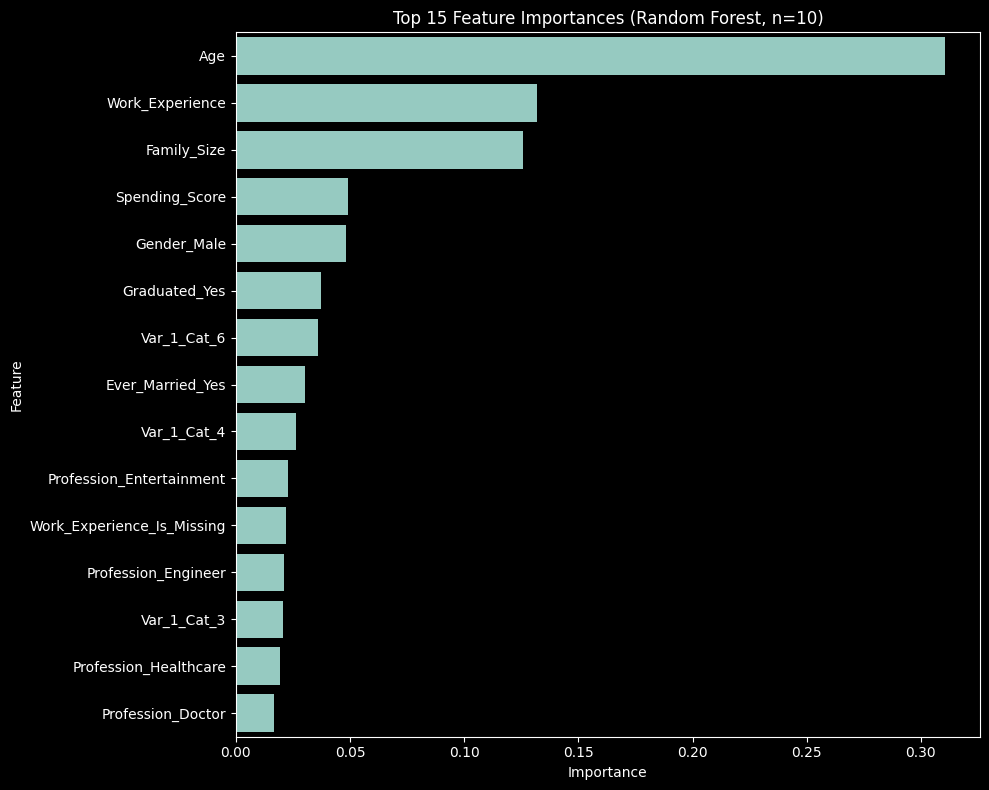

In [12]:
best_n = 10
print(f"\n--- Detailed Analysis for Random Forest with n_estimators = {best_n} ---")

best_rf_classifier = RandomForestClassifier(n_estimators=best_n, random_state=42, n_jobs=-1)
best_rf_classifier.fit(X_train, y_train)

y_pred_best = best_rf_classifier.predict(X_val)

print("\nSample Predictions on the Test (Validation) Set:")
predictions_df = pd.DataFrame({'Actual': y_val.values, 'Predicted': y_pred_best})
print(predictions_df.head(15).to_string())

print("\n\n--- Performance Metrics ---")

print(f"Overall Accuracy: {accuracy_score(y_val, y_pred_best):.4f}\n")

print("Classification Report:")
print(classification_report(y_val, y_pred_best))

print("Confusion Matrix:")
cm = confusion_matrix(y_val, y_pred_best, labels=best_rf_classifier.classes_)
cm_df = pd.DataFrame(cm, index=best_rf_classifier.classes_, columns=best_rf_classifier.classes_)
print(cm_df)


print("\n\n--- Feature Importance Analysis ---")

importances = best_rf_classifier.feature_importances_
feature_names = X_train.columns

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("Top 10 Most Important Features:")
print(feature_importance_df.head(10).to_string(index=False))

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15))
plt.title(f'Top 15 Feature Importances (Random Forest, n={best_n})')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()